It is well-documented that conventional Message Passing Graph Neural Networks (*MPGNNs*, with the [GCN layer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) used in this notebook falling into this category) have limited expressivity and are limited by effects such as oversmoothing, oversquashing, and underreaching. This has spurred extensive research into new model architectures for graph datasets, graph transformers being one major line of research there. With these new architectures, a whole lot of papers managed to improve significantly compared to *MPGNNs*. However, it could later be shown  that this gap in a lot of cases may be significantly smaller than suggested or even non-existent (in some cases) if *MPGNNs* architectures are properly optimized, hyperparameters are properly optimized, and models are evaluated on a comparable hyperparameter budget. E.g., Dwivedi et al. showed that using residual skip connections and laplacian eigenvectors as positional encodings (which are also commonly used by graph transformers) can significantly improve results for *MPGNNs*:
- [Dwivedi et al., Benchmarking Graph Neural Networks. **2022**](https://arxiv.org/pdf/2003.00982)

Similar, it could be shown that graph transformers may not necessarily be better than *MPGNNs* at learning long-range relationships as previously implied. E.g., Cai et al. and Tönshoff et al. show that the implied gap between graph transformers and *MPGNNs* vanishes if hyperparameters are properly optimized and virtual nodes are used:
- [Cai et al. On the Connection Between MPNN and Graph Transformer. **2023**](https://arxiv.org/pdf/2301.11956)
- [Tönshoff et al. Where Did the Gap Go? Reassessing the Long-Range Graph Benchmark. **2023**](https://arxiv.org/pdf/2309.00367)

In this notebook, we are trying to reproduce some of the results from Dwivedi et al. Specifically, we will train a GCN model with 16 layers (while staying belower the parameter budget of 500k hyperparameters) on the ZINC12k dataset. Dwivedi et al. achieved a mean absolute error of 0.278 on the ZINC12k test dataset there. We will study the effect of virtual nodes, positional encoding by laplacian eigenvectors, and additionally try to find out if using [DropPath](https://arxiv.org/pdf/1605.07648v4) (which is a technique used for residual networks in computer vision) has any effect for *MPGNNS*. Let's define our model architectures:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import ZINC
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.nn.aggr import (
    MultiAggregation, MeanAggregation, StdAggregation, SoftmaxAggregation)
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5

class DropPath(nn.Module):
    def __init__(self, droppath_prob):
        super(DropPath, self).__init__()
        self.drop_prob = droppath_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  
        mask = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        mask.floor_() 
        output = x.div(keep_prob) * mask
        return output


class MLP(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        modules = []
        for i in range(len(neurons) - 1):
            modules.append(nn.Linear(neurons[i], neurons[i+1]))
            if i != len(neurons) - 2:
                modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*modules)
        self.apply(self._initalize)

    def forward(self, x):
        return self.mlp(x)
    
    def _initalize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GCNLayer(nn.Module):
    def __init__(
            self, in_channels, out_channels, residual, dropout, droppath):
        super().__init__()
        self.gcn = GCNConv(in_channels, out_channels, 
                           improved=True
                           )
        self.bn = BatchNorm(out_channels)
        self.residual = residual
        self.dropout = dropout
        self.apply(self._initalize)
        self.droppath = DropPath(droppath)
        
    def forward(self, x, edge_index, edge_weight):
        x_in = x
        x = self.gcn(F.relu(x), edge_index, edge_weight)
        x = self.bn(x)
        x = self.droppath(x)
        if self.residual:
            x = x + x_in
            
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
    def _initalize(self, module):
        if isinstance(module, GCNConv):
            torch.nn.init.xavier_uniform_(module.lin.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                           
    
class GNN(nn.Module):
    def __init__(
            self, depth, laplacian_pe, k, graph_embeddings, num_atom_types,
            atom_embeddings, atom_embeddings_dropout, gcn_dropout, 
            dropout, mlp_factors, droppath, feat_out):
        super().__init__()
        self.embed_atoms = nn.Embedding(num_atom_types, atom_embeddings)
        self.dropout_embed_atoms = atom_embeddings_dropout
        self.laplacian_pe = laplacian_pe
        self.k = k
        self.gnn = nn.ModuleList(
            [GCNLayer(atom_embeddings + k, graph_embeddings, False, 
                      gcn_dropout, droppath)] + 
            [GCNLayer(graph_embeddings, graph_embeddings, True, 
                      gcn_dropout, droppath) for _ in range(depth-1)            
            ])
        
        self.agg = MultiAggregation([MeanAggregation(), StdAggregation(), 
                                     SoftmaxAggregation(t=0.1, learn=True)])
        self.dropout = dropout
        mlp_neurons = [graph_embeddings * f for f in mlp_factors] + [feat_out]
        self.mlp = MLP(mlp_neurons)

    def forward(self, x, edge_index, edge_weight, pe, batch):  
        if self.laplacian_pe:       
            x = torch.concatenate((
                F.dropout(self.embed_atoms(x)[:, 0, :], 
                          p=self.dropout_embed_atoms, training=self.training), 
                pe), axis=-1)
        else:
            x = self.embed_atoms(x)          
            x = F.dropout(
                x, p=self.dropout_embed_atoms, training=self.training)[:, 0, :]
            
        for gnn_layer in self.gnn:
            x = gnn_layer(x, edge_index, edge_weight)

        x = self.agg(x, batch)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)[:, 0]      
        return x

And let's start training:

Number of parameters: 421694


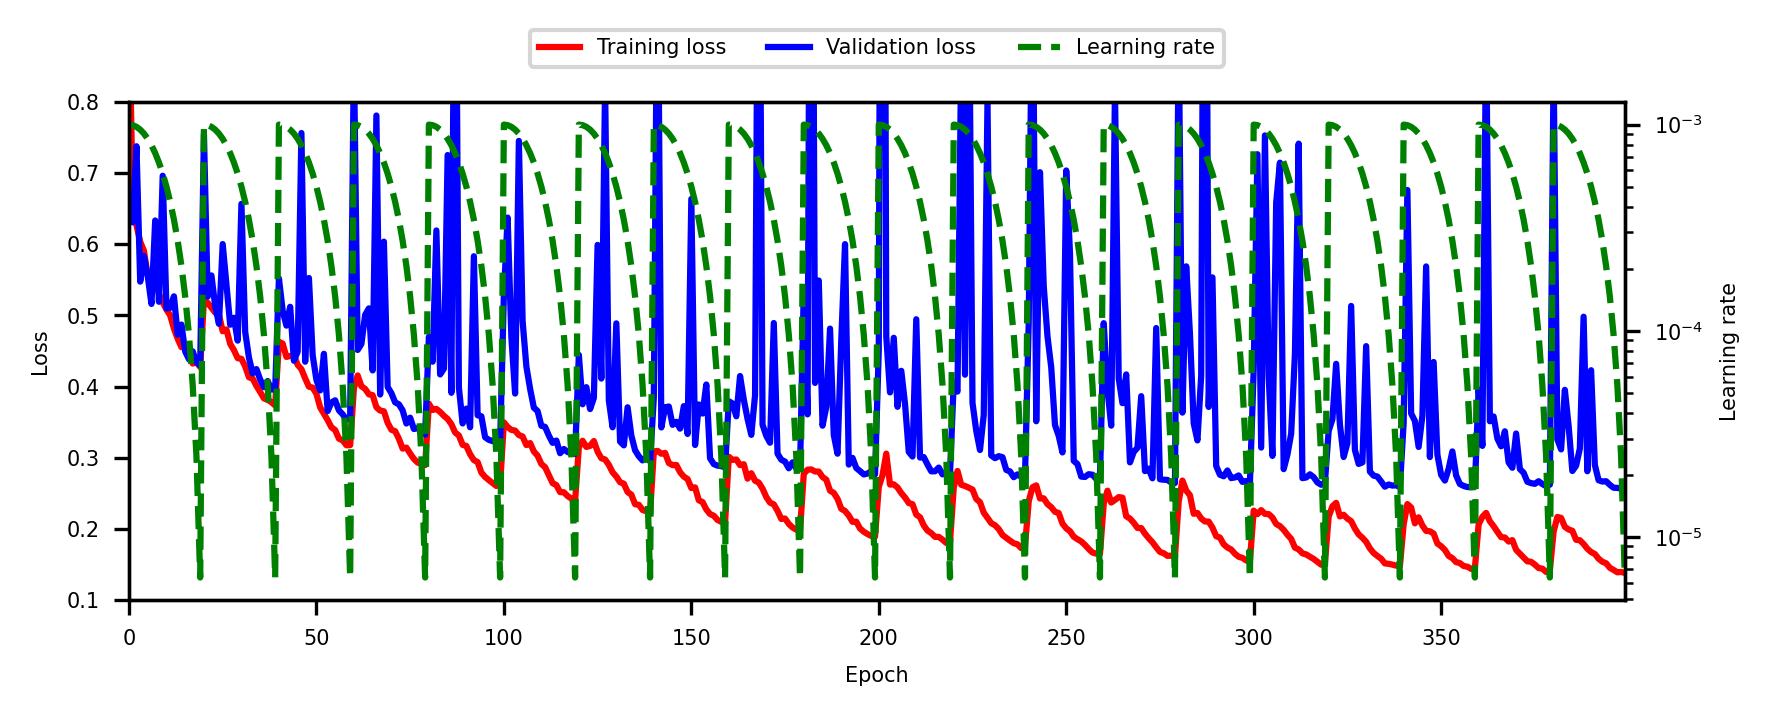

Number of parameters: 421694


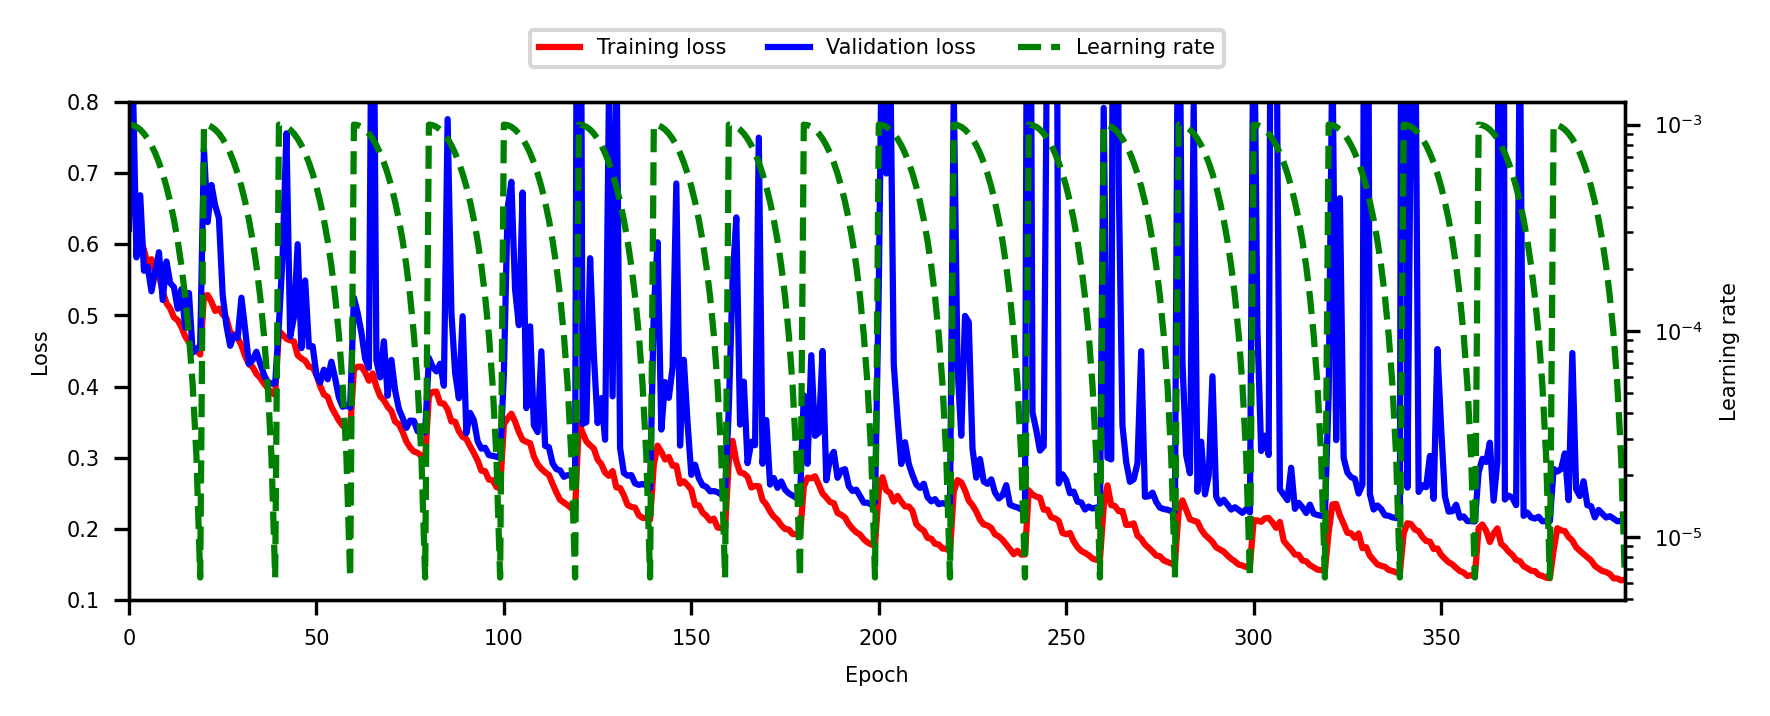

Number of parameters: 422270


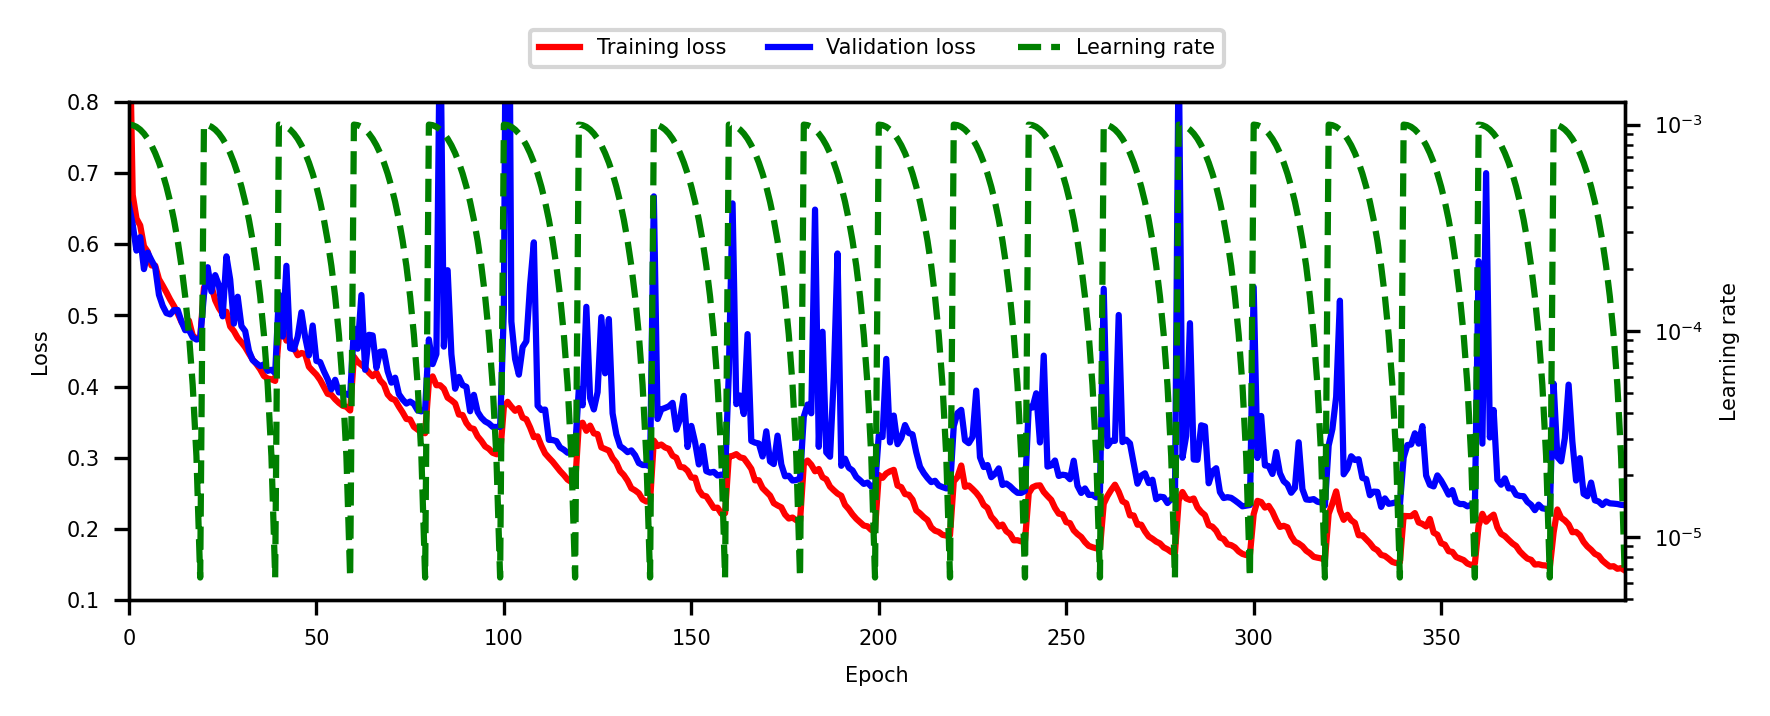

Number of parameters: 422270


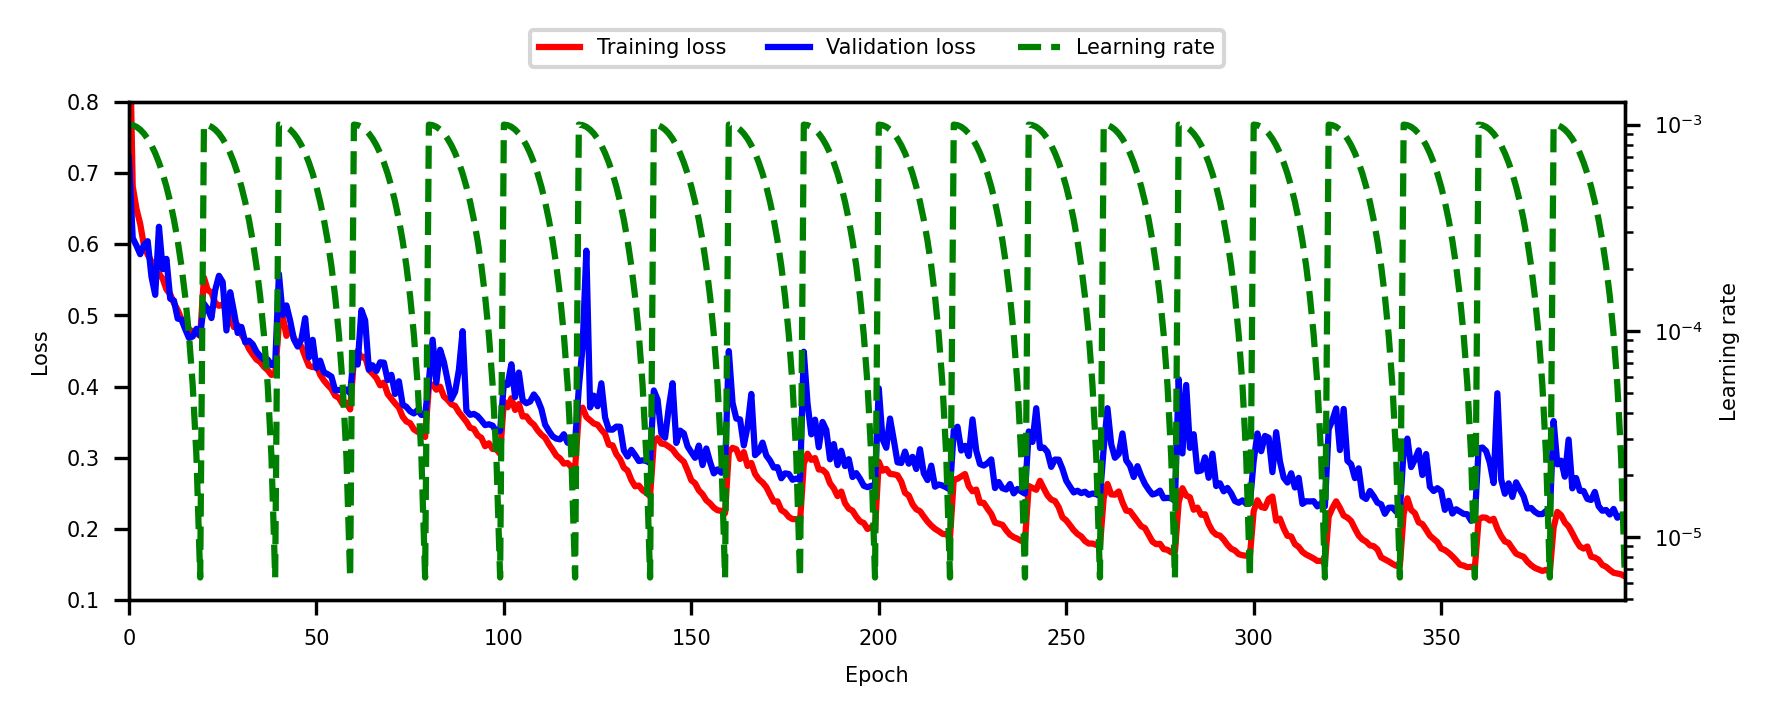

Number of parameters: 421694


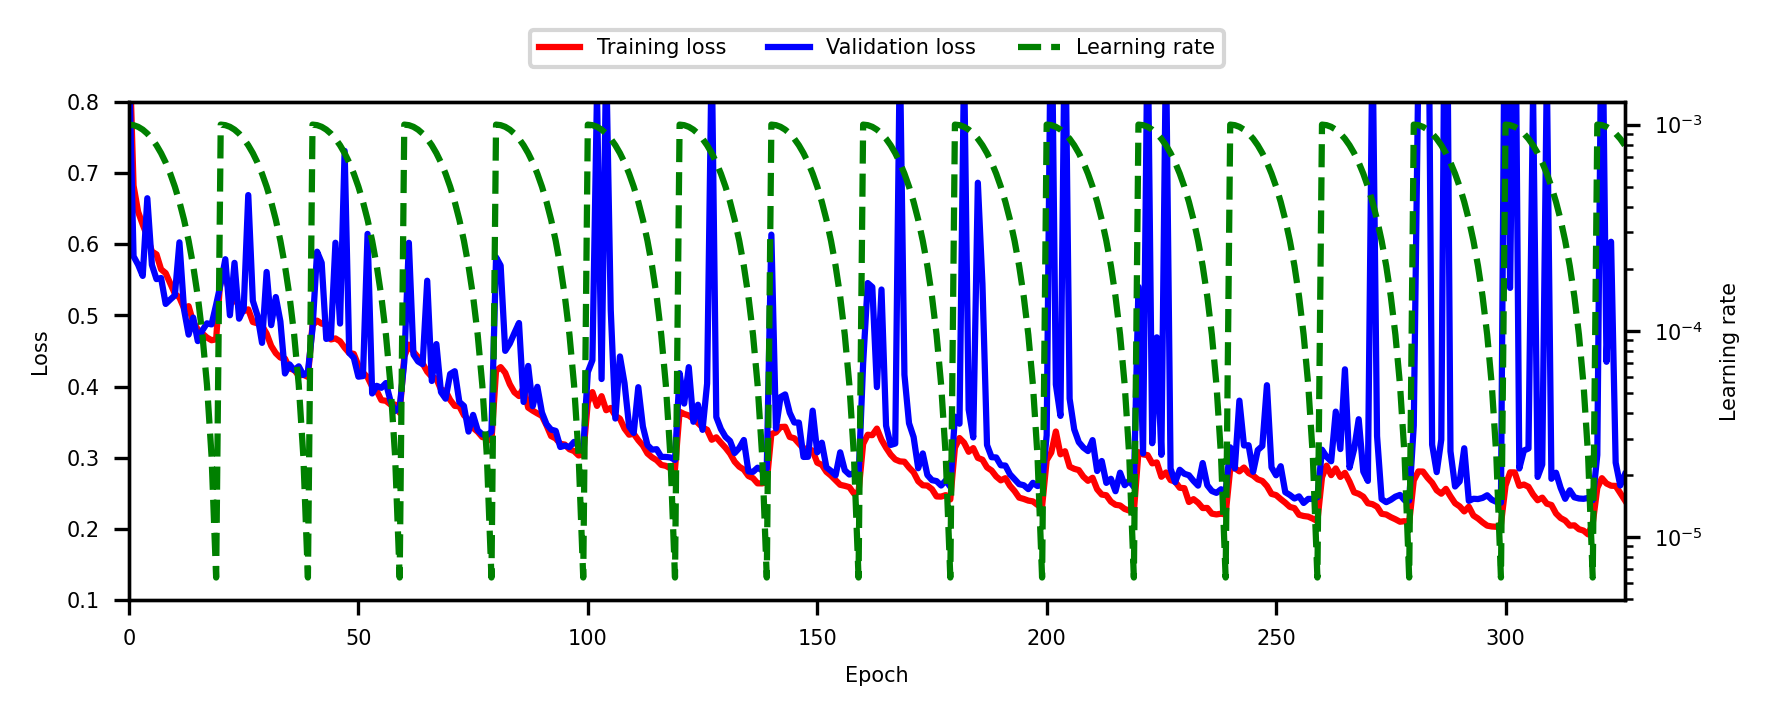

  Virtual node laplacian_PE DropPath MAE_test
0        False        False     0.00    0.234
1         True        False     0.00    0.184
2        False         True     0.00    0.205
3         True         True     0.00    0.197
4         True        False     0.02    0.216


In [2]:
class TrainingModule(pl.LightningModule):
    def __init__(
            self, depth, laplacian_pe, k, graph_embeddings, num_atom_types, 
            atom_embeddings, atom_embeddings_dropout, gcn_dropout, dropout, 
            droppath, mlp_factors, feat_out, batch_size):
        super().__init__()
        self.model = GNN(
            depth=depth, laplacian_pe=laplacian_pe, k=k, 
            graph_embeddings=graph_embeddings, 
            num_atom_types=num_atom_types, 
            atom_embeddings=atom_embeddings,
            atom_embeddings_dropout=atom_embeddings_dropout, 
            gcn_dropout=gcn_dropout, dropout=dropout, droppath=droppath,
            mlp_factors=mlp_factors, feat_out=feat_out)
        self.laplacian_pe = laplacian_pe
        self.criterion = nn.L1Loss()
        self.batch_size = batch_size

    def forward(self, x, edge_index, edge_weight, pe, batch):
        return self.model(x, edge_index, edge_weight.float(), pe, batch)

    def training_step(self, batch, batch_idx):
        if self.laplacian_pe:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  batch.pe, batch.batch)
        else:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  None, batch.batch)
        loss = self.criterion(y_pred, batch.y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if self.laplacian_pe:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  batch.pe, batch.batch)
        else:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  None, batch.batch)
        loss = self.criterion(y_pred, batch.y)
        self.log("val_loss", loss, on_step=False, on_epoch=True,
                 prog_bar=True, batch_size=self.batch_size)
        return loss
    
    @torch.no_grad()
    def predict_step(self, batch, batch_idx):
        self.model.eval()
        if self.laplacian_pe:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  batch.pe, batch.batch)
        else:
            y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                                  None, batch.batch)
        return y_pred

    def configure_optimizers(self):
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.train_scheduler = {
            "scheduler": CosineAnnealingWarmRestarts(
                optimizer=self.opt, T_0=20, T_mult=1, eta_min=2e-7),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"}
        return [self.opt], [self.train_scheduler]


def display_training_progress(trainer):
    logs = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]


    fig, ax0 = plt.subplots(figsize=(6, 2.5))
    l0 = ax0.plot(epochs, logs["train_loss"].dropna(), color="r", 
                  label="Training loss")
    l1 = ax0.plot(epochs, logs["val_loss"].dropna(), color="b", 
                  label="Validation loss")
    ax0.set_xlabel("Epoch", fontsize=5)
    ax0.set_ylabel("Loss", fontsize=5)
    ax0.set_xlim(0, len(epochs)-1)
        
    ax1 = ax0.twinx() 
    l2 = ax1.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
        label="Learning rate")
    ax1.set_ylabel("Learning rate", fontsize=5)
    ax1.set_yscale("log")
    ax0.set_ylim(0.1, 0.8)
    ax0.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center", 
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3, fontsize=5)
    plt.tight_layout()
    plt.show()
    return fig


def train_model_on_ZINC(
        model_name, transform, laplacian_pe, k, droppath, batch_size=64,
        depth=16, graph_embeddings=96, num_atom_types=21, atom_embeddings=12, 
        atom_embeddings_dropout=0.0, gcn_dropout=0.0, dropout=0.2, 
        mlp_factors=[3, 6, 2], feat_out=1, patience_early_stopping=70, 
        epochs=400):
    if transform is not None:
        ds_train = ZINC("./", split="train", subset=True, transform=transform)
        ds_val = ZINC("./", split="val", subset=True, transform=transform)
        ds_test = ZINC("./", split="test", subset=True, transform=transform)
    else:
        ds_train = ZINC("./", split="train", subset=True)
        ds_val = ZINC("./", split="val", subset=True)
        ds_test = ZINC("./", split="test", subset=True)
        
    loader_train = DataLoader(ds_train, batch_size, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size, shuffle=False)
    loader_test = DataLoader(ds_test, batch_size, shuffle=False)

    cb_a = ModelCheckpoint(monitor="val_loss", mode="min")
    cb_b = EarlyStopping(
        monitor="val_loss", mode="min", patience=patience_early_stopping)
    cb_c = LearningRateMonitor(logging_interval="epoch")
    logger = CSVLogger(save_dir="logs/", name=model_name,
                       flush_logs_every_n_steps=1)

    model = TrainingModule(
        depth=depth, laplacian_pe=laplacian_pe, k=k, 
        graph_embeddings=graph_embeddings, num_atom_types=num_atom_types, 
        atom_embeddings=atom_embeddings,
        atom_embeddings_dropout=atom_embeddings_dropout, 
        gcn_dropout=gcn_dropout, dropout=dropout, droppath=droppath,
        mlp_factors=mlp_factors, feat_out=feat_out, batch_size=batch_size)
    
    print(f"Number of parameters: {nn.utils.parameters_to_vector(model.model.parameters()).numel()}")

    trainer = pl.Trainer(
        max_epochs=epochs, check_val_every_n_epoch=1, # accelerator="gpu",
        callbacks=[cb_a, cb_b, cb_c], logger=logger, enable_progress_bar=False)
    trainer.fit(
        model=model, train_dataloaders=loader_train, val_dataloaders=loader_val)
    fig = display_training_progress(trainer)

    checkpoint_file = trainer.checkpoint_callback.best_model_path
    model = TrainingModule.load_from_checkpoint(
        checkpoint_file, depth=depth, laplacian_pe=laplacian_pe, k=k, 
        graph_embeddings=graph_embeddings, num_atom_types=num_atom_types, 
        atom_embeddings=atom_embeddings, 
        atom_embeddings_dropout=atom_embeddings_dropout, 
        gcn_dropout=gcn_dropout, dropout=dropout, droppath=droppath,
        mlp_factors=mlp_factors, feat_out=feat_out, batch_size=batch_size)
    
    y_test_pred = torch.cat(trainer.predict(model, dataloaders=loader_test))
    y_test_true = torch.cat([b.y for b in loader_test])
    mae_test = np.mean(np.abs(y_test_true.numpy() - y_test_pred.numpy()))
    
    return mae_test, fig
    

mae_test0, fig0 = train_model_on_ZINC(
    "model00", transform=None, laplacian_pe=False, k=0, droppath=0.0)
mae_test1, fig1 = train_model_on_ZINC(
    "model01", transform=T.Compose([T.VirtualNode()]), laplacian_pe=False, 
    k=0, droppath=0.0)
mae_test2, fig2 = train_model_on_ZINC(
    "model02", transform=T.Compose([
        T.AddLaplacianEigenvectorPE(k=6, attr_name="pe")]), laplacian_pe=True, 
    k=6, droppath=0.0)
mae_test3, fig3 = train_model_on_ZINC(
    "model03", transform=T.Compose([
        T.VirtualNode(),
        T.AddLaplacianEigenvectorPE(k=6, attr_name="pe")]), laplacian_pe=True, 
    k=6, droppath=0.0)
mae_test4, fig4 = train_model_on_ZINC(
    "model04", transform=T.Compose([T.VirtualNode()]), laplacian_pe=False, 
    k=0, droppath=0.02)


results = [("False", "False", "0.00", f"{mae_test0:.3f}"),
           ("True", "False", "0.00", f"{mae_test1:.3f}"),
           ("False", "True", "0.00", f"{mae_test2:.3f}"),
           ("True", "True", "0.00", f"{mae_test3:.3f}"),
           ("True", "False", "0.02", f"{mae_test4:.3f}"),
           ]
df = pd.DataFrame.from_records(
    results, columns=["Virtual node", "laplacian_PE", "DropPath", "MAE_test"])

print(df)

In this notebook, we had a second look at the work from Dwivedi et al. ([Dwivedi et al., Benchmarking Graph Neural Networks. **2022**](https://arxiv.org/pdf/2003.00982)). Specifically, we trained a GCN model with 16 layers (while staying below the parameter budget of 500k hyperparameters) on the ZINC12k dataset - just like Dwivedi et al. Dwivedi et al. achieved a mean absolute error of 0.278 on the ZINC12k test dataset there. In this notebook, our best model achieves a mean absolute error of 0.184 on the ZINC12k test dataset. This represents a significant improvement and shows what was already discussed in the introduction: Many studies do not necessary push it to the limit (and this notebook also falls into this category), therefore one should frequently not jump to conclusion too quickly. 

The best performance in this notebook was observed when employing a virtual node. This beat out Laplacian positional encoding. However, even in the most simplistic setup without any virtual node or positional encoding a mean absolute error of 0.234 was achieved beating out results from Dwivedi et al. Reasons for that might be that the aggregation scheme in this notebook is different, edge features were used as edge weights in the GCN layer, and it was trained for a bit longer/with a different learning rate schedule. DropPath was found to be not benificial in this notebook.